# Neural Storyteller: Image Captioning with Seq2Seq

## Objective
Build a multimodal deep learning model that generates natural language descriptions for images using a Sequence-to-Sequence (Seq2Seq) architecture.

## 1. Environment Setup & Imports

In [53]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import numpy as np
import nltk
import pickle
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# Ensure NLTK data is downloaded (quietly)
nltk.download('punkt', quiet=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
BATCH_SIZE = 64
NUM_WORKERS = 2
EMBED_SIZE = 256
HIDDEN_SIZE = 512
VOCAB_THRESHOLD = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
OUTPUT_FILE = 'flickr30k_features.pkl'

Using device: cuda


## 2. Dataset Paths
Strictly checking for Flickr30k dataset.

In [54]:
# --- STRICT PATH CONFIGURATION ---
# We prioritize the specific dataset path for 'adityajn105'
POSSIBLE_IMG_PATHS = [
    '/kaggle/input/datasets/adityajn105/flickr30k/Images',
    '/kaggle/input/flickr30k/Images',
    '/kaggle/input/flickr30k/flickr30k_images/flickr30k_images'
]

IMAGE_DIR = None
for path in POSSIBLE_IMG_PATHS:
    if os.path.exists(path):
        IMAGE_DIR = path
        break

if IMAGE_DIR is None:
    # Searching as last resort
    print("Searching for images...")
    for root, dirs, files in os.walk('/kaggle/input'):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            IMAGE_DIR = root
            break

if not IMAGE_DIR:
    raise FileNotFoundError("CRITICAL ERROR: Could not find Flickr30k images. Please check dataset attachment.")

print(f"✅ Found Image Directory: {IMAGE_DIR}")

# --- CAPTIONS FILE ---
# Try to find captions.txt relative to the image dir or in standard paths
POSSIBLE_CAP_PATHS = [
    '/kaggle/input/datasets/adityajn105/flickr30k/captions.txt',
    '/kaggle/input/flickr30k/captions.txt',
    os.path.join(os.path.dirname(IMAGE_DIR), 'captions.txt'),
    os.path.join(os.path.dirname(os.path.dirname(IMAGE_DIR)), 'captions.txt')
]

CAPTION_FILE = None
for path in POSSIBLE_CAP_PATHS:
    if os.path.exists(path):
        CAPTION_FILE = path
        break

if not CAPTION_FILE:
     print("WARNING: Could not find captions.txt in standard paths. Searching...")
     for root, dirs, files in os.walk('/kaggle/input'):
        if 'captions.txt' in files:
            CAPTION_FILE = os.path.join(root, 'captions.txt')
            break

if not CAPTION_FILE:
    raise FileNotFoundError("CRITICAL ERROR: Could not find captions.txt. Please check dataset attachment.")

print(f"✅ Found Caption File: {CAPTION_FILE}")

✅ Found Image Directory: /kaggle/input/datasets/adityajn105/flickr30k/Images
✅ Found Caption File: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt


## 3. Part 1: Feature Extraction Pipeline (ResNet50)
We use a pre-trained ResNet50 to convert each image into a 2048-dimensional feature vector and cache it.

In [55]:
# Simple dataset just to yield images for feature extraction
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# Feature Extraction Logic
def extract_features():
    if os.path.exists(OUTPUT_FILE):
        print(f"{OUTPUT_FILE} already exists. Loading...")
        with open(OUTPUT_FILE, 'rb') as f:
            return pickle.load(f)
            
    print("Extracting features from images...")
    resnet = models.resnet50(pretrained=True)
    # Remove the last FC layer to get 2048-dim features
    modules = list(resnet.children())[:-1]
    model = nn.Sequential(*modules)
    model = model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    dataset = ImageFolderDataset(IMAGE_DIR, transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    features_dict = {}
    with torch.no_grad():
        for imgs, names in tqdm(loader, desc="Extracting"):
            imgs = imgs.to(device)
            # Forward pass
            feats = model(imgs)
            # Flatten (batch, 2048, 1, 1) -> (batch, 2048)
            feats = feats.view(feats.size(0), -1)
            
            cpu_feats = feats.cpu().numpy()
            for i, name in enumerate(names):
                features_dict[name] = cpu_feats[i]

    with open(OUTPUT_FILE, 'wb') as f:
        pickle.dump(features_dict, f)
    
    return features_dict

# Run extraction (or load if exists)
if IMAGE_DIR:
    features_dict = extract_features()
    print(f"Features loaded for {len(features_dict)} images.")
else:
    print("WARNING: Image directory not found, skipping extraction for testing.")
    features_dict = {}

flickr30k_features.pkl already exists. Loading...
Features loaded for 31783 images.


## 4. Part 2: Vocabulary & Text Pre-Processing

In [56]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [57]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, features_dict, freq_threshold=5, transform=None):
        self.features_dict = features_dict
        self.transform = transform
        
        # --- ROBUST CSV LOADING ---
        self.df = None
        
        # Method 1: Try reading with different delimiters
        delimiters = [',', '|', '\t']
        for d in delimiters:
            try:
                temp_df = pd.read_csv(captions_file, delimiter=d)
                if len(temp_df.columns) > 1:
                    self.df = temp_df
                    break
            except:
                continue
        
        # Method 2: Fallback to engine='python'
        if self.df is None or len(self.df.columns) < 2:
            try:
                self.df = pd.read_csv(captions_file, sep=None, engine='python')
            except:
                pass

        # Method 3: Manual split for merged columns
        if self.df is not None and len(self.df.columns) == 1:
            col_name = self.df.columns[0]
            if ',' in col_name:
                # Read as text and split
                with open(captions_file, 'r') as f:
                    lines = f.readlines()
                data = [line.strip().split(',') for line in lines]
                # Careful with variable length lines, take only valid ones
                valid_data = [d for d in data if len(d) >= 2]
                if valid_data:
                    # Assume first line is header if fails, or just use 0 and -1
                    self.df = pd.DataFrame(valid_data)

        # Safety Check
        if self.df is None or len(self.df.columns) == 0:
             self.df = pd.DataFrame(columns=['image_name', 'comment'])

        # --- Standardizing Columns ---
        self.df.columns = [str(c).lower().strip() for c in self.df.columns]
        
        rename_map = {
            'image': 'image_name',
            'image_id': 'image_name',
            'caption': 'comment',
            'description': 'comment',
            'desc': 'comment',
            'image_name|comment_number|comment': 'image_name'
        }
        self.df.rename(columns=rename_map, inplace=True)
        
        # Force rename by position if still missing
        if 'image_name' not in self.df.columns:
            cols = list(self.df.columns)
            if len(cols) >= 2:
                cols[0] = 'image_name'
                cols[-1] = 'comment'
                self.df.columns = cols
        
        # Final Error if still broken
        if 'image_name' not in self.df.columns:
             raise KeyError(f"CRITICAL: Could not find 'image_name'. Columns found: {self.df.columns.tolist()}. Please check your captions.txt file path.")

        # Dropna
        self.df.dropna(inplace=True)
        self.imgs = self.df['image_name']
        self.captions = self.df['comment']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions.iloc[index]
        img_name = self.imgs.iloc[index]

        if img_name in self.features_dict:
            img_feature = torch.tensor(self.features_dict[img_name]).float()
        else:
            img_feature = torch.zeros(2048).float()

        numericalized_caption = [self.vocab.stoi["<START>"]]
        numericalized_caption += self.vocab.numericalize(str(caption))
        numericalized_caption.append(self.vocab.stoi["<END>"])

        return img_feature, torch.tensor(numericalized_caption)

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        features = [item[0].unsqueeze(0) for item in batch]
        features = torch.cat(features, dim=0) 
        
        targets = [item[1] for item in batch]
        targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return features, targets

## 5. Part 3: The Seq2Seq Architecture

In [62]:
class Encoder(nn.Module):
    def __init__(self, input_size=2048, embed_size=256):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, features):
        # Features: (batch, 2048)
        # Output: (batch, embed_size)
        embed = self.linear(features)
        embed = self.bn(embed)
        embed = self.relu(embed)
        return self.dropout(embed)

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # features: (batch, embed_size)
        # captions: (batch, seq_len)
        
        # Embed the captions
        embeddings = self.dropout(self.embed(captions))
        # (batch, seq_len, embed_size)
        
        # Concatenate features as the first step of the sequence
        # We unsqueeze features to be (batch, 1, embed_size)
        features = features.unsqueeze(1)
        
        # Input to LSTM: [features, caption_word_1, caption_word_2, ...]
        # We usually discard the last <END> token for training target alignment
        inputs = torch.cat((features, embeddings[:, :-1, :]), dim=1)
        
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(2048, embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, features, captions):
        encoded_features = self.encoder(features)
        outputs = self.decoder(encoded_features, captions)
        return outputs
    
    def caption_image(self, features, vocabulary, max_length=20):
        # Greedy Search
        result_caption = []
        
        with torch.no_grad():
            x = self.encoder(features).unsqueeze(1) # (1, 1, embed)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted = output.argmax(1)
                
                result_caption.append(predicted.item())
                
                x = self.decoder.embed(predicted).unsqueeze(1)

                if vocabulary.itos[predicted.item()] == "<END>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

    def caption_image_beam_search(self, features, vocabulary, beam_size=3, max_length=20):
        # Beam Search
        k = beam_size
        start_token = vocabulary.stoi["<START>"]
        end_token = vocabulary.stoi["<END>"]
        device = features.device
        
        with torch.no_grad():
            # Initial encode: Ensure simple (1, 2048) batch dim
            if features.dim() == 1:
                features = features.unsqueeze(0)
                
            # Encoder output -> (1, embed) -> (1, 1, embed)
            encoded_feat = self.encoder(features).unsqueeze(1)
            
            # Initial step to get first hidden state
            # h, c shape: (num_layers, batch=1, hidden_size)
            h, c = self.decoder.lstm(encoded_feat, None)[1]
            
            # Beams store: (cumulative_score, list_of_token_indices, (h, c))
            beams = [(0, [start_token], (h, c))]
            
            for _ in range(max_length):
                candidates = []
                
                # Expand each beam
                for score, seq, (h, c) in beams:
                    if seq[-1] == end_token:
                        candidates.append((score, seq, (h, c)))
                        continue
                    
                    # Prepare input for next step
                    last_token_idx = seq[-1]
                    
                    # CORRECTION HERE: 
                    # Embed returns (1, embed_size). 
                    # We want (1, 1, embed_size).
                    # So we use .unsqueeze(1) ONCE.
                    x = self.decoder.embed(torch.tensor([last_token_idx]).to(device)).unsqueeze(1)
                    
                    # Ensure hidden states are contiguous tensors for LSTM
                    h_in = h.contiguous()
                    c_in = c.contiguous()
                    
                    # LSTM Step
                    out, (h_next, c_next) = self.decoder.lstm(x, (h_in, c_in))
                    
                    # Predict next word
                    output = self.decoder.linear(out.squeeze(1)) # (1, vocab)
                    probs = torch.nn.functional.log_softmax(output, dim=1)
                    topk_probs, topk_ids = probs.topk(k)
                    
                    for i in range(k):
                        word_idx = topk_ids[0][i].item()
                        word_prob = topk_probs[0][i].item()
                        new_score = score + word_prob
                        new_seq = seq + [word_idx]
                        candidates.append((new_score, new_seq, (h_next, c_next)))
                
                # Order all candidates by score
                ordered = sorted(candidates, key=lambda x: x[0], reverse=True)
                beams = ordered[:k]
                
                # If all top k beams ended, stop early
                if all(b[1][-1] == end_token for b in beams):
                    break
            
            best_seq = beams[0][1]
            return [vocabulary.itos[idx] for idx in best_seq if idx not in [start_token, end_token]]

## 6. Part 4: Training Loop

In [63]:
full_dataset = FlickrDataset(
    captions_file=CAPTION_FILE,
    features_dict=features_dict,
    freq_threshold=VOCAB_THRESHOLD
)

# Split Dataset (Train/Val)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

pad_idx = full_dataset.vocab.stoi["<PAD>"]
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=Collate(pad_idx=pad_idx)
)

# Initialize Model
vocab_size = len(full_dataset.vocab)
model = Seq2Seq(EMBED_SIZE, HIDDEN_SIZE, vocab_size, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training
print(f"Training on {len(train_set)} samples, Validating on {len(val_set)} samples")
loss_history = []

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for idx, (features, captions) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}"):
        features = features.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(features, captions)
        
        # Calculate loss (flatten outputs and targets)
        # Targets are captions shifted by one (we predict next word)
        # Output shape: (batch, seq_len, vocab)
        # Target shape: (batch, seq_len)
        loss = criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

# Save Model & Vocab
torch.save(model.state_dict(), "neural_storyteller.pth")
with open('vocab.pkl', 'wb') as f:
    pickle.dump(full_dataset.vocab, f)
print("Model and Vocabulary saved.")

Training on 143022 samples, Validating on 15892 samples


Epoch 1: 100%|██████████| 2235/2235 [01:05<00:00, 34.33it/s]

Epoch 1 Average Loss: 3.3203



Epoch 2: 100%|██████████| 2235/2235 [01:05<00:00, 34.36it/s]

Epoch 2 Average Loss: 2.7971



Epoch 3: 100%|██████████| 2235/2235 [01:04<00:00, 34.63it/s]

Epoch 3 Average Loss: 2.6459



Epoch 4: 100%|██████████| 2235/2235 [01:05<00:00, 34.25it/s]

Epoch 4 Average Loss: 2.5560



Epoch 5: 100%|██████████| 2235/2235 [01:04<00:00, 34.43it/s]

Epoch 5 Average Loss: 2.4909
Model and Vocabulary saved.


## 7. Deliverables: Evaluation & Inference

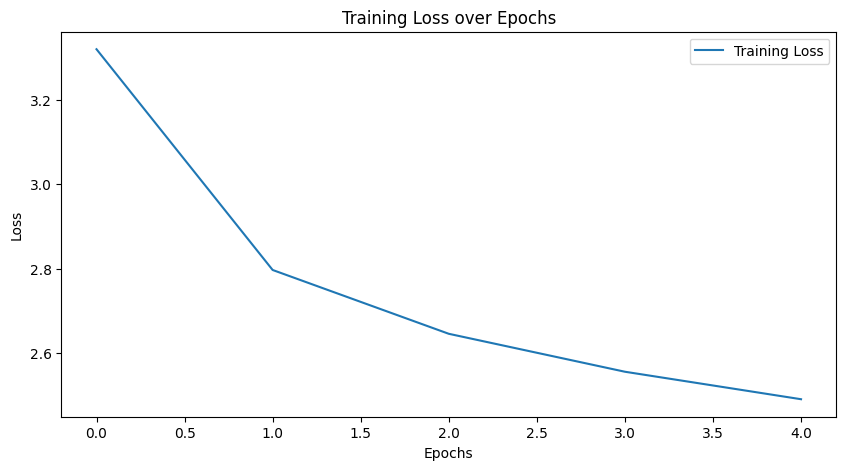

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


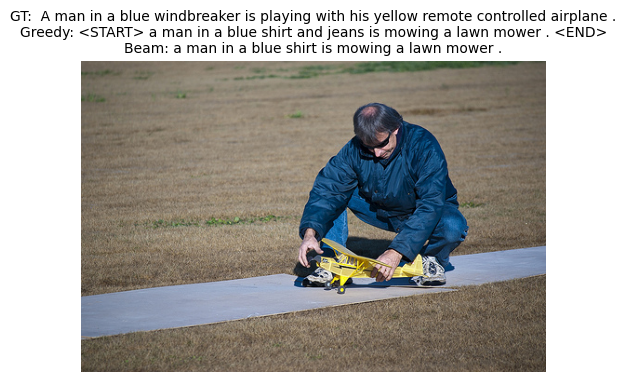

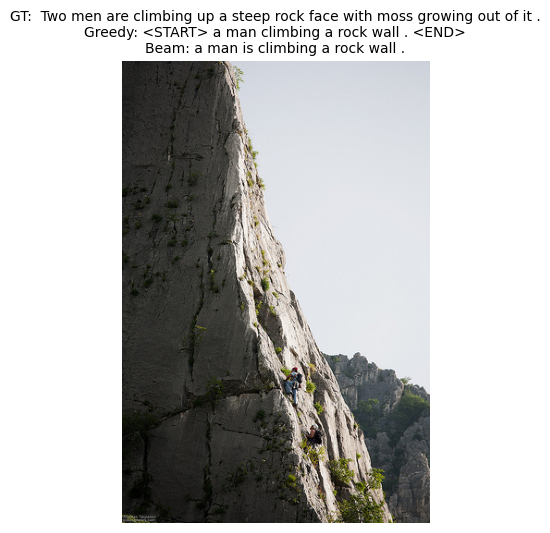

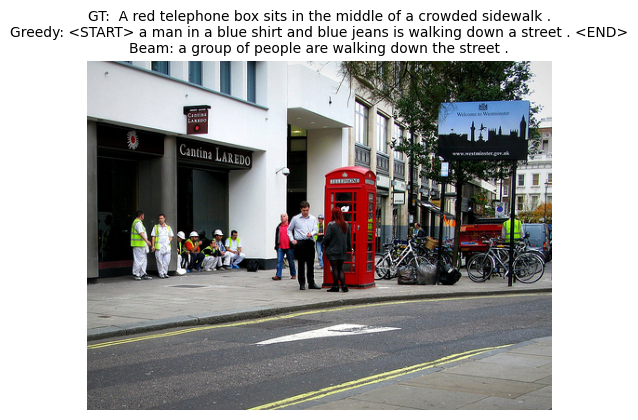

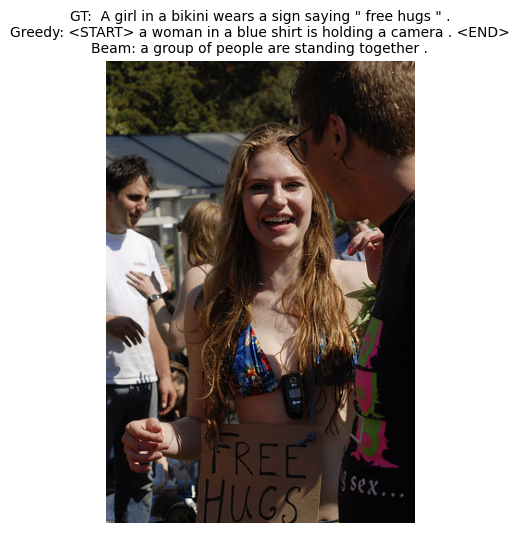

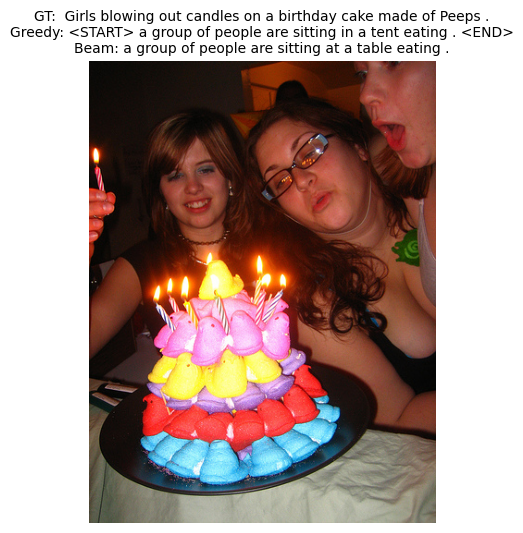

In [64]:
# 1. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Inference Examples
model.eval()

def generate_caption(img_path, method='greedy'):
    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Get features using ResNet (Need to re-instantiate or use cached if available)
    # Here we simulate the feature extraction for a NEW image
    resnet = models.resnet50(pretrained=True)
    modules = list(resnet.children())[:-1]
    resnet_extractor = nn.Sequential(*modules).to(device)
    resnet_extractor.eval()

    with torch.no_grad():
        feature = resnet_extractor(img_tensor)
        feature = feature.view(feature.size(0), -1)
    
    if method == 'beam':
        caption = model.caption_image_beam_search(feature, full_dataset.vocab)
    else:
        caption = model.caption_image(feature, full_dataset.vocab)
        
    return " ".join(caption)

# Display 5 Random Examples from Validation Set
if IMAGE_DIR:
    import random
    
    # Get 5 random images from val set (need to access underlying dataframe/indices)
    # We'll just pick random indices from the full dataset for simplicity
    indices = random.sample(range(len(full_dataset)), 5)
    
    for idx in indices:
        img_name = full_dataset.df.iloc[idx]['image_name']
        img_path = os.path.join(IMAGE_DIR, img_name)
        
        if os.path.exists(img_path):
            original_caption = full_dataset.df.iloc[idx]['comment']
            
            pred_greedy = generate_caption(img_path, method='greedy')
            pred_beam = generate_caption(img_path, method='beam')
            
            plt.figure(figsize=(6,6))
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"GT: {original_caption}\nGreedy: {pred_greedy}\nBeam: {pred_beam}", fontsize=10)
            plt.show()